# <h1><center>CodeIT AI Engineer 3기 Mission 3</center></h1>



### 문제
여러분이 자전거 대여 시스템의 운영 담당자라고 상상해 보세요.
<br />
여러분의 목표는 자전거 대여 패턴을 분석하여 자전거 배치 및 운영 전략을 최적화하고, 대여 수요를 정확히 예측하는 것입니다. 이를 통해 대여 시스템의 효율성을 높이고 사용자 만족도를 증가시키는 방법을 찾는 것이 이번 미션의 핵심입니다.


이번 미션의 최종 목표는 RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추는 것입니다. 다양한 머신러닝 모델과 전략을 실험하여 가장 정확한 수요 예측 모델을 개발하고, 그 결과를 보고서에 담아 보세요!

<br />

---




### 목표

자전거 대여의 수요 예측을 통해 시스템의 효율성을 향상시키고, 사용자 만족도를 끌어올릴 방법을 찾기위해 자전거 대여 패턴을 분석하여 자전거 배치 및 운영 전략을 최적화 해보자.

<br />

---



### 데이터 SET
<br />

|컬럼명|컬럼타입|설명|
|---|---|---|
|datetime|datetime|자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00|
|season|int|계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)|
|holiday|int|공휴일 여부 (0: 평일, 1: 공휴일)|
|workingday|int|근무일 여부 (0: 주말/공휴일, 1: 근무일)|
|weather|int|날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설)|
|temp|float|실측 온도 (섭씨)|
|atemp|float|체감 온도 (섭씨)|
|humidity|int|습도 (%)|
|windspeed|float|풍속 (m/s)|
|casual|int|등록되지 않은 사용자의 대여 수|
|registered|int|등록된 사용자의 대여 수|
|count|int|총 대여 수 (종속 변수)|


- train.csv 파일에는 count 컬럼이 포함되어 있으며, 예측 대상인 종속 변수입니다.
- test.csv 파일에는 casual, registered, count 컬럼이 포함되어 있지 않습니다.
casual과 registered는 자전거 대여 수요를 예측하는데 참고하실만한 자료이며, count는 두 컬럼간의 합입니다.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# read dataset
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

## 1. 데이터 탐색

### 데이터 확인

In [3]:
print(train_df.shape)
train_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


### 데이터 1차 확인 결과

- train: 전체 10886행 12열의 구조
- test: 전체 6493행 8열의 구조

---


- 행 한줄 한줄이 시간단위로 기록 된 구조로 확인됨
- 실측 온도와 체감 온도는 0도 밑으로 존재 하지 않음


## 데이터 전처리

In [7]:
# 중복값 확인
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [8]:
original_columns = test_df.columns.tolist()

# datetime 파싱 및 피처 생성
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# 공통 피처 생성
for df in [train_df, test_df]:
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int) # 주말


In [9]:
print('train_data 총 수:', len(train_df.index), '주말 수:', len(train_df[train_df['is_weekend'] == 1].index))
print('test_data 총 수:', len(test_df.index), '주말 수:', len(test_df[test_df['is_weekend'] == 1].index))

train_data 총 수: 10886 주말 수: 3163
test_data 총 수: 6493 주말 수: 1851


In [10]:
train_df[(train_df['is_weekend'] == 1)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,month,year,is_weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,5,1,2011,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,5,1,2011,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,5,1,2011,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,5,1,2011,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,5,1,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10809,2012-12-16 19:00:00,4,0,0,1,14.76,17.425,93,8.9981,10,99,109,19,6,12,2012,1
10810,2012-12-16 20:00:00,4,0,0,2,15.58,19.695,82,0.0000,14,108,122,20,6,12,2012,1
10811,2012-12-16 21:00:00,4,0,0,2,14.76,18.940,93,0.0000,14,92,106,21,6,12,2012,1
10812,2012-12-16 22:00:00,4,0,0,2,16.40,20.455,82,12.9980,6,83,89,22,6,12,2012,1


In [11]:
## holiday, workingday 유효성 검사
print('holiday: ', train_df[(train_df['is_weekend'] == 1) & (train_df['holiday'] == 0)], end='\n\n') # 토,일 인 데이터와 holiday의 공휴일 비교
print('workingday: ', train_df[(train_df['is_weekend'] == 1) & (train_df['workingday'] == 1)]) # 토,일 인 데이터와 workingday의 주말/공휴일 비교

print('holiday: ', test_df[(test_df['is_weekend'] == 1) & (test_df['holiday'] == 0)], end='\n\n') # 토,일 인 데이터와 holiday의 공휴일 비교
print('workingday: ', test_df[(test_df['is_weekend'] == 1) & (test_df['workingday'] == 1)]) # 토,일 인 데이터와 workingday의 주말/공휴일 비교

holiday:                   datetime  season  holiday  workingday  weather   temp  \
0     2011-01-01 00:00:00       1        0           0        1   9.84   
1     2011-01-01 01:00:00       1        0           0        1   9.02   
2     2011-01-01 02:00:00       1        0           0        1   9.02   
3     2011-01-01 03:00:00       1        0           0        1   9.84   
4     2011-01-01 04:00:00       1        0           0        1   9.84   
...                   ...     ...      ...         ...      ...    ...   
10809 2012-12-16 19:00:00       4        0           0        1  14.76   
10810 2012-12-16 20:00:00       4        0           0        2  15.58   
10811 2012-12-16 21:00:00       4        0           0        2  14.76   
10812 2012-12-16 22:00:00       4        0           0        2  16.40   
10813 2012-12-16 23:00:00       4        0           0        2  14.76   

        atemp  humidity  windspeed  casual  registered  count  hour  \
0      14.395        81     0.

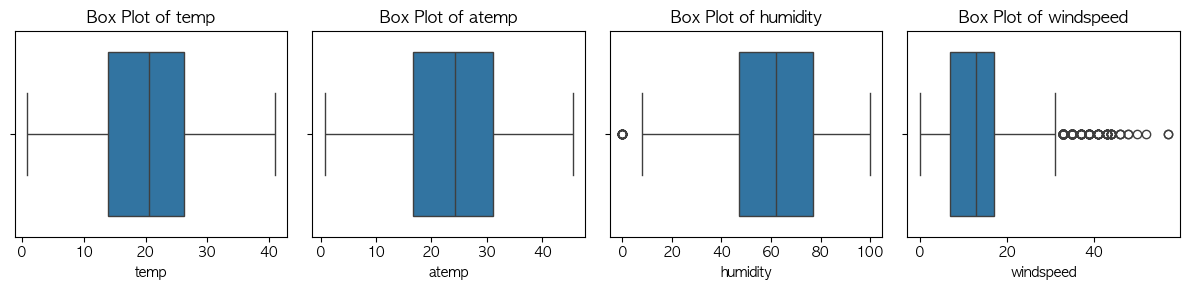

In [12]:
# 이상치 시각화
num_cols = ['temp', 'atemp', 'humidity', 'windspeed']

plt.figure(figsize=(12, 3))

cnt = 1
for i, col in enumerate(num_cols):
    plt.subplot(1, 4, cnt)
    sns.boxplot(data=train_df, x=col)
    plt.title(f'Box Plot of {col}')

    cnt += 1

plt.tight_layout()
plt.show()


In [13]:
# 습도가 0인 데이터는 이상치로 판단해 제거함
print(train_df[train_df['humidity'] == 0]['humidity'].count())
print(test_df[test_df['humidity'] == 0]['humidity'].count())

train_df.drop(train_df[train_df['humidity'] == 0].index, inplace=True)

22
0


In [14]:
# 풍속이 20만 넘어도 폭풍, 태풍수준인데 러프하게 40이상은 이상치로 판단
print(train_df[train_df['windspeed'] > 40]['windspeed'].count())
print(test_df[test_df['windspeed'] > 40]['windspeed'].count())

train_df.drop(train_df[train_df['windspeed'] > 40].index, inplace=True)
test_df.drop(test_df[test_df['windspeed'] > 40].index, inplace=True)

40
23


In [15]:
# test 데이터는 온도차가 고르게 분포되어있으나,
# train 데이터에는 12.08.17 실측온도에 이상치가 존재함. 제거

# 실측온도와 체감온도 차이 계산
train_df['temp_diff'] = abs(train_df['temp'] - train_df['atemp'])
test_df['temp_diff'] = abs(test_df['temp'] - test_df['atemp'])

train_df.drop(train_df[train_df['temp_diff'] > 13].index, inplace=True)

# 차이가 큰 순서로 정렬
train_temp_diff = train_df[['datetime', 'temp', 'atemp', 'temp_diff']].sort_values(by='temp_diff', ascending=False)
test_temp_diff = test_df[['datetime', 'temp', 'atemp', 'temp_diff']].sort_values(by='temp_diff', ascending=False)

print(train_temp_diff)
print(test_temp_diff)

                datetime   temp   atemp  temp_diff
8303 2012-07-07 08:00:00  33.62  41.665      8.045
3301 2011-08-07 11:00:00  33.62  41.665      8.045
3300 2011-08-07 10:00:00  32.80  40.150      7.350
2423 2011-06-08 21:00:00  32.80  40.150      7.350
3139 2011-07-19 17:00:00  32.80  40.150      7.350
...                  ...    ...     ...        ...
5132 2011-12-07 22:00:00   9.84   9.850      0.010
603  2011-02-08 07:00:00   9.84   9.850      0.010
608  2011-02-08 12:00:00   9.84   9.850      0.010
609  2011-02-08 13:00:00   9.84   9.850      0.010
5138 2011-12-08 04:00:00   9.84   9.850      0.010

[10800 rows x 4 columns]
                datetime   temp   atemp  temp_diff
1605 2011-07-21 21:00:00  33.62  44.695     11.075
1603 2011-07-21 19:00:00  35.26  46.210     10.950
1623 2011-07-22 15:00:00  38.54  49.240     10.700
1621 2011-07-22 13:00:00  38.54  49.240     10.700
1622 2011-07-22 14:00:00  39.36  50.000     10.640
...                  ...    ...     ...        ...
6453 

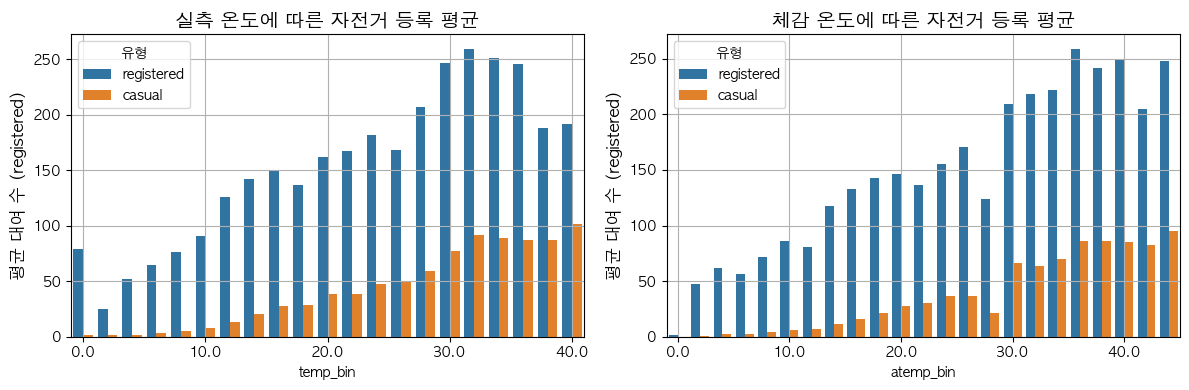

In [16]:
# 실측 온도 구간별 registered/casual 평균
train_df['temp_bin'] = (train_df['temp'] // 2) * 2
temp_reg_cas = train_df.groupby('temp_bin')[['registered', 'casual']].mean().reset_index().melt(id_vars='temp_bin', var_name='유형', value_name='평균 대여 수')

# 체감 온도 구간별 registered/casual 평균
train_df['atemp_bin'] = (train_df['atemp'] // 2) * 2
atemp_reg_cas = train_df.groupby('atemp_bin')[['registered', 'casual']].mean().reset_index().melt(id_vars='atemp_bin', var_name='유형', value_name='평균 대여 수')


# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=temp_reg_cas, x='temp_bin', y='평균 대여 수', hue='유형', ax=axes[0])
axes[0].set_title('실측 온도에 따른 자전거 등록 평균', fontsize=14)
axes[0].set_ylabel('평균 대여 수 (registered)', fontsize=12)
axes[0].set_xticks(range(0, 25, 5))
axes[0].grid(True)

sns.barplot(data=atemp_reg_cas, x='atemp_bin', y='평균 대여 수', hue='유형', ax=axes[1])
axes[1].set_title('체감 온도에 따른 자전거 등록 평균', fontsize=14)
axes[1].set_ylabel('평균 대여 수 (registered)', fontsize=12)
axes[1].set_xticks(range(0, 25, 5))
axes[1].grid(True)

plt.tight_layout()
plt.show()

train_df.drop(columns=['temp_bin', 'atemp_bin'], inplace=True)

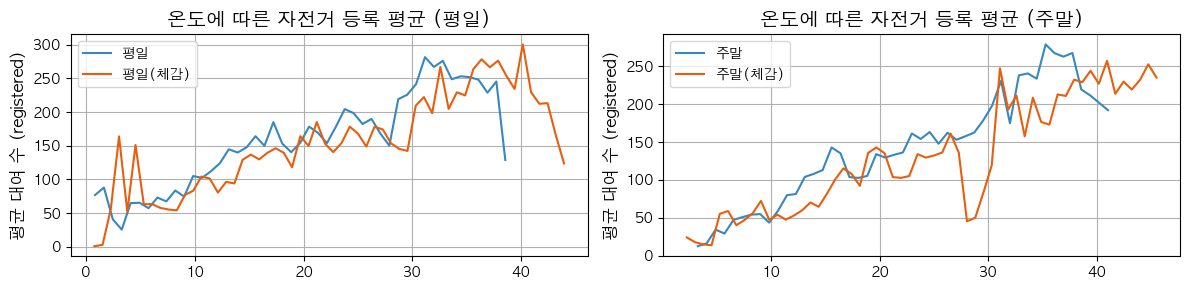

In [17]:
temp_registered = train_df.groupby(['is_weekend', 'temp'])['registered'].mean().reset_index()
temp_registered['구분'] = temp_registered['is_weekend'].map({0: '평일', 1: '주말'})

atemp_registered = train_df.groupby(['is_weekend', 'atemp'])['registered'].mean().reset_index()
atemp_registered['구분'] = atemp_registered['is_weekend'].map({0: '평일(체감)', 1: '주말(체감)'})


# 시각화
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.lineplot(data=temp_registered[temp_registered['is_weekend'] == 0], x='temp', y='registered', hue='구분', palette='Blues_d')
sns.lineplot(data=atemp_registered[atemp_registered['is_weekend'] == 0], x='atemp', y='registered', hue='구분', palette='Oranges_d')
plt.title('온도에 따른 자전거 등록 평균 (평일)', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 대여 수 (registered)', fontsize=12)
plt.grid(True)
plt.legend()

# 시각화
plt.subplot(1, 2, 2)
sns.lineplot(data=temp_registered[temp_registered['is_weekend'] != 0], x='temp', y='registered', hue='구분', palette='Blues_d')
sns.lineplot(data=atemp_registered[atemp_registered['is_weekend'] != 0], x='atemp', y='registered', hue='구분', palette='Oranges_d')
plt.title('온도에 따른 자전거 등록 평균 (주말)', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 대여 수 (registered)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

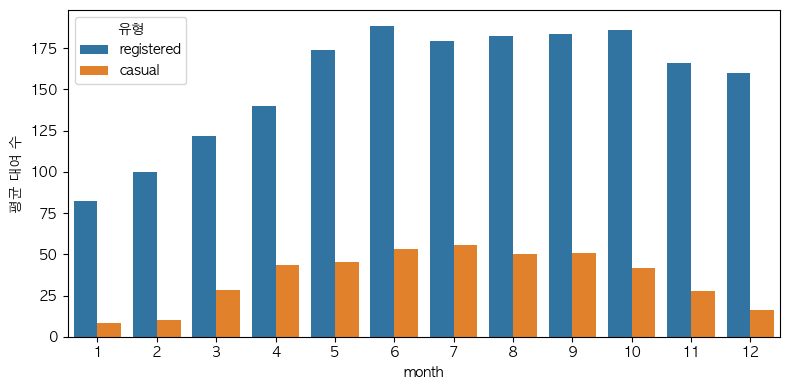

In [18]:
# month

# 월별 registered/casual 평균
month_reg_cas = train_df.groupby('month')[['registered', 'casual']].mean().reset_index().melt(id_vars='month', var_name='유형', value_name='평균 대여 수')


plt.figure(figsize=(8, 4))
sns.barplot(data=month_reg_cas, x='month', y='평균 대여 수', hue='유형')
plt.tight_layout()
plt.show()

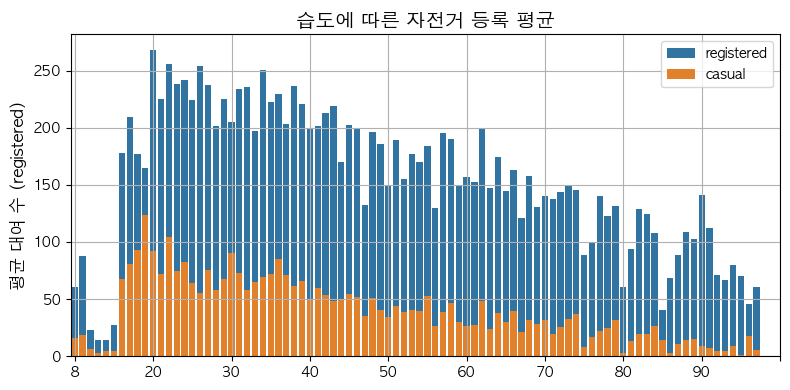

In [19]:
humidity_registered = train_df.groupby(['humidity'])[['registered', 'casual']].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=humidity_registered, x='humidity', y='registered', label="registered")
sns.barplot(data=humidity_registered, x='humidity', y='casual', label="casual")
plt.title('습도에 따른 자전거 등록 평균', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 대여 수 (registered)', fontsize=12)
plt.xticks(range(0, 100, 10))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

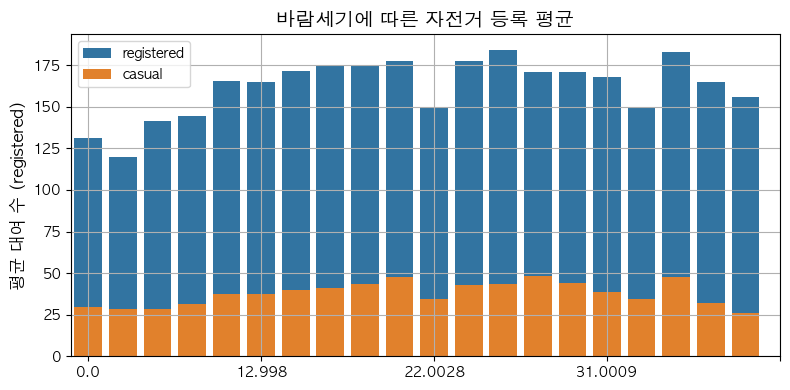

In [20]:
# 주말/평일 + 시간대별 평균 대여 수요
windspeed_registered = train_df.groupby(['windspeed'])[['registered', 'casual']].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 4))
sns.barplot(data=windspeed_registered, x='windspeed', y='registered', label="registered")
sns.barplot(data=windspeed_registered, x='windspeed', y='casual', label="casual")
plt.title('바람세기에 따른 자전거 등록 평균', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 대여 수 (registered)', fontsize=12)
plt.xticks(range(0, 25, 5))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

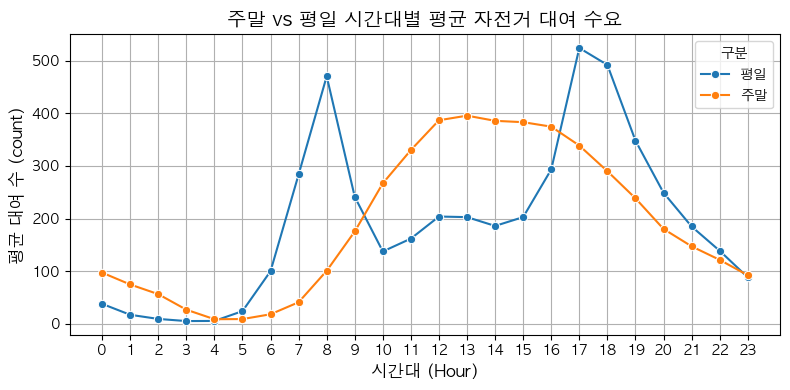

In [21]:
# 주말/평일 + 시간대별 평균 대여 수요
hour_weekend_count = train_df.groupby(['is_weekend', 'hour'])['count'].mean().reset_index()
hour_weekend_count['구분'] = hour_weekend_count['is_weekend'].map({0: '평일', 1: '주말'})

# 시각화
plt.figure(figsize=(8, 4))
sns.lineplot(data=hour_weekend_count, x='hour', y='count', hue='구분', marker='o')
plt.title('주말 vs 평일 시간대별 평균 자전거 대여 수요', fontsize=14)
plt.xlabel('시간대 (Hour)', fontsize=12)
plt.ylabel('평균 대여 수 (count)', fontsize=12)
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title='구분')
plt.tight_layout()
plt.show()

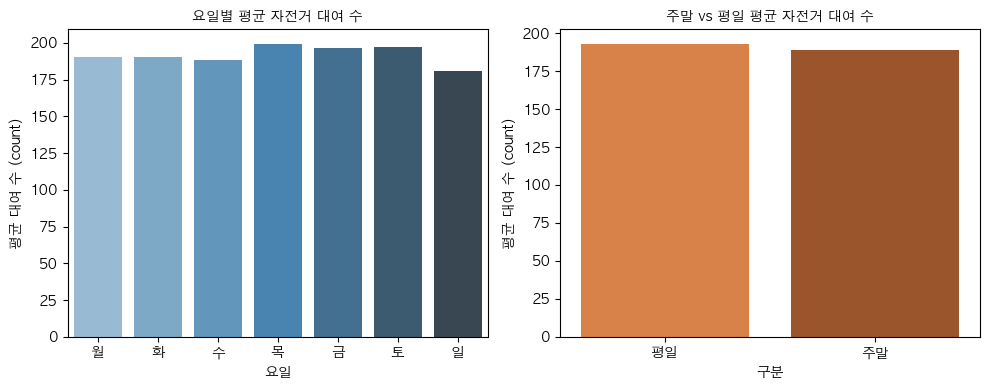

In [22]:
# 요일별 평균 대여량
dayofweek_count = train_df.groupby('dayofweek')['count'].mean().reset_index()
dayofweek_count.columns = ['요일', '평균 대여 수']

# 주말/평일별 평균 대여량
weekend_count = train_df.groupby('is_weekend')['count'].mean().reset_index()
weekend_count['구분'] = weekend_count['is_weekend'].map({0: '평일', 1: '주말'})
weekend_count = weekend_count[['구분', 'count']]
weekend_count.columns = ['구분', '평균 대여 수']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 요일별 평균 대여 수
sns.barplot(data=dayofweek_count, x='요일', y='평균 대여 수', ax=axes[0], palette='Blues_d')
axes[0].set_title('요일별 평균 자전거 대여 수', fontsize=10)
axes[0].set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
axes[0].set_xlabel('요일', fontsize=10)
axes[0].set_ylabel('평균 대여 수 (count)', fontsize=10)

# 주말/평일 평균 대여 수
sns.barplot(data=weekend_count, x='구분', y='평균 대여 수', ax=axes[1], palette='Oranges_d')
axes[1].set_title('주말 vs 평일 평균 자전거 대여 수', fontsize=10)
axes[1].set_xlabel('구분', fontsize=10)
axes[1].set_ylabel('평균 대여 수 (count)', fontsize=10)

plt.tight_layout()
plt.show()

### 데이터 2차 확인 결과

- holiday 열 설명이 실 데이터와는 반대로 확인이 됩니다.
- 기온이 낮을수록 전반적인 대여량이 감소하는것이 확인됩니다.
- 주중에는 출퇴근 시간대에 대여량이 증가합니다.
- 주말에는 출퇴근 피크는 없으나 대여량이 10시부터 증가해 12~15시 정점도달 후 점진적으로 감소합니다.



## 모델링

In [23]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,dayofweek,month,year,is_weekend,temp_diff
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,2011,0,0.705
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,2011,0,2.975
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,2011,0,2.975
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,2011,0,2.220
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,2011,0,2.220


In [24]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,month,year,is_weekend,temp_diff
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011,1,4.555
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011,1,4.615
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,2011,1,4.615
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,2011,1,4.555
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,2011,1,4.555


In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_squared_log_error
from sklearn.pipeline import make_pipeline

In [26]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)  # 음수 방지
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 훈련용 데이터 재정의

# 요일/시간대/월 기준 그룹핑 → 평균 대여량 구함
peak_profile = train_df.groupby(['is_weekend', 'hour', 'month'])['count'].mean().reset_index()
peak_profile = peak_profile.rename(columns={'count': 'peak_weight'})
if 'peak_weight' not in train_df.columns:
    train_df = train_df.merge(peak_profile, on=['is_weekend', 'hour', 'month'], how='left')

train_df['weather_severe'] = (train_df['weather'] > 2).astype(int)
train_df['hour_squared'] = train_df['hour'] ** 2
train_df['env_score'] = (
    -0.5 * (train_df['atemp'] - 20)**2           # 체감온도: 20도 중심
    - 0.2 * (train_df['humidity'] - 50)**2       # 습도: 50% 중심
    - 1.5 * (train_df['windspeed'] - 3)**2       # 바람: 2.5 m/s 중심
)

# 테스트 데이터 동일한 전처리
test_df = test_df.merge(peak_profile, on=['is_weekend', 'hour', 'month'], how='left')
test_df['weather_severe'] = (test_df['weather'] > 2).astype(int)
test_df['hour_squared'] = test_df['hour'] ** 2
test_df['env_score'] = (
    -0.5 * (test_df['atemp'] - 20)**2           # 체감온도: 20도 중심
    - 0.2 * (test_df['humidity'] - 50)**2       # 습도: 50% 중심
    - 1.5 * (test_df['windspeed'] - 3)**2       # 바람: 2.5 m/s 중심
)

features = train_df.columns.tolist()
features.remove('registered')
features.remove('casual')
features.remove('count')
features.remove('datetime')
features.remove('workingday')
features.remove('holiday')
features.remove('year')
features.remove('weather')
features.remove('season')
features.remove('dayofweek')

In [27]:
X = train_df[features]
y = train_df['count']

# Ridge alpha 찾기
alphas = [0.1, 1, 10, 100, 300, 500, 1000]
for a in alphas:
    model = Ridge(alpha=a)
    score = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
    print(f"alpha={a}, 평균 RMSE={-score.mean():.4f}")

alpha=0.1, 평균 RMSE=105.6933
alpha=1, 평균 RMSE=105.6869
alpha=10, 평균 RMSE=105.6457
alpha=100, 평균 RMSE=105.5180
alpha=300, 평균 RMSE=105.4508
alpha=500, 평균 RMSE=105.4467
alpha=1000, 평균 RMSE=105.4605


In [28]:
def 모델_테스트(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # 다항 회귀 파이프라인 (2차)
    poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), Ridge(alpha=300))

    # 교차 검증 (5-Fold)
    r2_scores = cross_val_score(poly_model, X_train, y_train, scoring='r2', cv=5)
    rmse_scores = cross_val_score(poly_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

    rmsle_scores = cross_val_score(poly_model, X_train, y_train, scoring=make_scorer(rmsle, greater_is_better=False), cv=5)

    # 결과 정리
    cv_df = pd.DataFrame({
        'Fold': list(range(1, 6)),
        'R2': r2_scores,
        'RMSE': -rmse_scores,
        'RMSLE': -rmsle_scores
    })
    cv_df.loc['평균'] = ['평균', cv_df['R2'].mean(), cv_df['RMSE'].mean(), cv_df['RMSLE'].mean()]
    print("✅ 교차 검증 결과:")
    print(cv_df, end='\n\n')


    # 훈련셋 평가
    poly_model.fit(X_train, y_train)
    y_train_pred = poly_model.predict(X_test)

    print("✅ 훈련 데이터 성능:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_train_pred)))
    print("RMSLE:", rmsle(y_test, y_train_pred))
    print("R²:", r2_score(y_test, y_train_pred))

모델_테스트(X, y)


✅ 교차 검증 결과:
   Fold        R2       RMSE     RMSLE
0     1  0.827875  74.639380  0.750054
1     2  0.828919  74.619390  0.719308
2     3  0.839886  72.422729  0.701989
3     4  0.841274  71.037183  0.742180
4     5  0.827653  74.042528  0.732625
평균   평균  0.833121  73.352242  0.729231

✅ 훈련 데이터 성능:
RMSE: 77.34812233110057
RMSLE: 0.7121364889852556
R²: 0.8290076694954469


In [29]:
# 피처 정의
X_train_final = train_df[features]
y_train_final = train_df['count']

X_test_final = test_df[features]

# 최종 모델 정의 및 학습
final_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=50)
)
final_model.fit(X_train_final, y_train_final)

# 예측 및 제출 파일 생성
preds = final_model.predict(X_test_final)
preds = np.maximum(preds, 0).round()

submission = test_df[original_columns].copy()
submission['count'] = preds

submission_path = "./submission.csv"
submission.to_csv(submission_path, index=False)